# Bayesian analysis of emotion-mediated memory



In this notebook I will conduct (somewhat) speedy Bayesian mixed-effects logistic regression to test how word-level features predict memory, with subject-level random effects. 


Notes
___


- Bambi needs up-to-date xarray (for 'unify_chunks' method), while the data I pickled used xarray 0.13.0 


- Bambi can't multi-process sampling across multiple chains if you import joblib, so need to make sure to only load in csv data. 

In [ ]:
import arviz as az
import bambi as bmb
import argparse
from os.path import join
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from Bayesian_model_utils import run_model, plot_res, print_latex_table, plot_predictions

: 

## How do arousal and valence predict recall performance?

In [2]:
# First, let's build our model and plot the priors to see if they're sensible 

# Old dataset of pts with Hipp or Amy electrodes 
behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv', low_memory=False)

# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# Center valence using mean of whole database to capture relative polarity
behav_df.valence = behav_df.valence - 0.5

behav_df = behav_df[['recalled', 'arousal', 'valence', 'subject']]

y = 'recalled'
X = ['arousal', 'valence'] 
Intx = ['arousal:valence']
rand_effect = ['subject']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Set some terms 
rand_term = [f'(1|{x})' for x in rand_effect]
formula = f'{y} ~ 1+'+'+'.join(rand_term)+'+'+'+'.join(X)+'+'+'+'.join(Intx)
model_fam = 'bernoulli'
priors=None
categorical=None

# construct the model 
model = bmb.Model(formula=formula, 
              data=behav_df[rand_effect + [y] + X],
             family=model_fam,
             priors=priors,
             categorical=categorical)

model.build()

model.plot_priors()

/tmp/2833564.1.jupyter.q/ipykernel_64249/589411149.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)


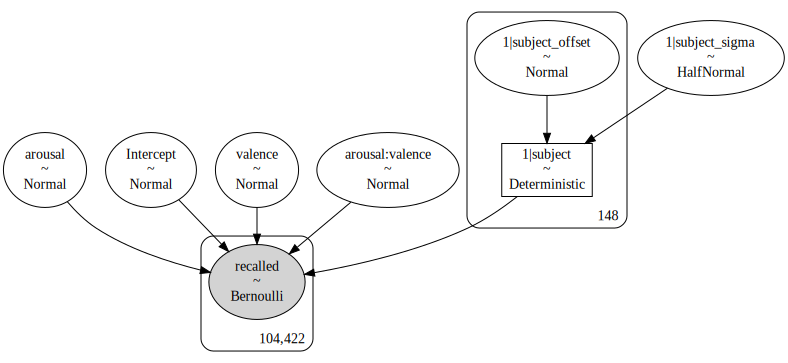

In [4]:
# Make the graphical model: 

model.graph()

Our model formulation looks sensible. Let's do it.

In [3]:
# Model 1: Effect of arousal and continuous, linear valence on recall 

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv', low_memory=False)

# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# Center valence using mean of whole database to capture relative polarity
behav_df.valence = behav_df.valence - 0.5

behav_df = behav_df[['recalled', 'arousal', 'valence', 'subject']]

y = 'recalled'
X = ['arousal', 'valence'] 
Intx = ['arousal:valence']
rand_effect = ['subject']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, 
          chains=4, cores=4, tune=1000, draws=1000, 
          label = label, rand_slopes=False)

/tmp/2818473.1.jupyter.q/ipykernel_17411/1045270821.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 24300
Interrupted at 24,299 [48%]: Average Loss = 67,729
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, arousal:valence, valence, arousal, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2172 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|}
\toprule
          index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
        arousal &  0.368 & 0.047 &     0.280 &      0.459 \\ \hline
arousal:valence & -0.174 & 0.242 &    -0.643 &      0.306 \\ \hline
        valence &  0.000 & 0.114 &    -0.224 &      0.220 \\ \hline
arousal:valence & -0.174 & 0.242 &    -0.643 &      0.306 \\ \hline
\bottomrule
\end{tabular}



In [ ]:
# Model 2: Effect of arousal and binned valence on recall 

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv', low_memory=False)

behav_df = behav_df.drop(columns=['Unnamed: 0'])

# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

behav_df = behav_df[['recalled', 'arousal', 'CV', 'subject']]

y = 'recalled'
X = ['arousal', 'CV'] 
Intx = ['arousal:CV']
rand_effect = ['subject']
# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, categorical=categorical, 
          chains=4, cores=4, tune=1000, draws=1000, 
          label = label, rand_slopes=False)

/tmp/2818473.1.jupyter.q/ipykernel_17411/1193381368.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 26400
Interrupted at 26,399 [52%]: Average Loss = 70,023
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, arousal:CV, CV, arousal, Intercept]


In [ ]:
# Model 3: Effect of arousal and squared valence on recall 

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all.csv', low_memory=False)

behav_df = behav_df.drop(columns=['Unnamed: 0'])

# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# Center valence using mean of whole database to capture relative polarity
behav_df.valence = behav_df.valence - 0.5

behav_df['valence_squared'] = behav_df.valence**2

behav_df = behav_df[['recalled', 'arousal', 'valence_squared', 'subject']]

y = 'recalled'
X = ['arousal', 'valence_squared'] 
Intx = ['arousal:valence_squared']
rand_effect = ['subject']
categorical =['CV'] 
# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, categorical=categorical, 
          chains=4, cores=4, tune=1000, draws=1000, 
          label = label, rand_slopes=False)

Let's now do model comparison using leave-one-out cross-validation and determine which formulation of valence is best for prediction. 

Source:
https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html

https://arviz-devs.github.io/arviz/api/generated/arviz.plot_compare.html

https://bambinos.github.io/bambi/main/notebooks/model_comparison.html?highlight=waic


In [ ]:
# Model comparison: use PSI-LOO

# Load each model
save_dir = '/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels'
linear_valence = az.from_netcdf(f'{save_dir}/recalled_arousal_valence_allFRpts_model')
valence_squared = az.from_netcdf(f'{save_dir}/recalled_arousal_valence_squared_allFRpts_model')
binned_valence = az.from_netcdf(f'{save_dir}/recalled_arousal_CV_allFRpts_model')

models = {"linear_valence": linear_valence, 
          "valence_squared": valence_squared,
         "binned_valence": binned_valence}

df_compare = az.compare(models, ic='loo')
plot_df = df_compare.reset_index().rename(columns={'index':'model'})[['model', 'loo']]

c_string = '|c'*plot_df.shape[1] + '|'
print(plot_df.to_latex(index=False, 
                                        column_format=c_string).replace("\\\n", "\\ \hline\n"))  
az.plot_compare(df_compare, insample_dev=True)
plt.savefig(f'{save_dir}/behav_valence_comparison.pdf')

In [ ]:
az.plot_compare(df_compare, insample_dev=True)
plt.savefig(f'{save_dir}/arousal_valence_comparison.pdf')

## How do arousal and valence interact with direct-brain stimulation ?

In [3]:
# Model 1: Effect of stimulation to Hipp only on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')

# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only hippocampal stim:
stim_behav_df = stim_behav_df[(stim_behav_df.stim_reg=='Hipp')]
 
# Center valence using mean of whole database to capture relative polarity
stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
stim_behav_df.stim_hemi = stim_behav_df.stim_hemi.astype(cat_type)

stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subject', 'is_stim', 'stim_hemi']]

y = 'recalled'
X = ['is_stim', 'arousal', 'valence', 'stim_hemi'] 
Intx = ['is_stim:arousal', 'is_stim:valence']

rand_effect = ['subject']
categorical = ['is_stim', 'stim_hemi']
label = (f"{y}" + "_{}"*len(X)).format(*X) + '_HippOnly' 

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=2000, draws=2000, target_accept=0.95,
          rand_slopes=False, categorical=categorical, label=label)

/tmp/2823834.1.jupyter.q/ipykernel_87061/2450537663.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 18700
Interrupted at 18,699 [37%]: Average Loss = 5,458.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, is_stim:valence, is_stim:arousal, stim_hemi, valence, arousal, is_stim, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 578 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|}
\toprule
               index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
        is\_stim[1.0] & -0.178 & 0.148 &    -0.459 &      0.123 \\ \hline
is\_stim:arousal[1.0] & -0.314 & 0.366 &    -0.991 &      0.433 \\ \hline
is\_stim:valence[1.0] &  0.697 & 0.353 &     0.003 &      1.375 \\ \hline
             arousal &  0.722 & 0.220 &     0.293 &      1.150 \\ \hline
is\_stim:arousal[1.0] & -0.314 & 0.366 &    -0.991 &      0.433 \\ \hline
             valence & -0.106 & 0.210 &    -0.495 &      0.315 \\ \hline
is\_stim:valence[1.0] &  0.697 & 0.353 &     0.003 &      1.375 \\ \hline
     stim\_hemi[left] & -0.520 & 0.299 &    -1.126 &      0.050 \\ \hline
\bottomrule
\end{tabular}



In [4]:
# Model 2: Effect of stimulation to MTL only on recall as a function of arousal and valence: 

stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')

# Get only encoding events
stim_behav_df = stim_behav_df[stim_behav_df.type=='WORD']

# Get only hippocampal stim:
stim_behav_df = stim_behav_df[(stim_behav_df.stim_reg=='MTL')]
 
# Center valence using mean of whole database to capture relative polarity
stim_behav_df['valence'] = stim_behav_df['valence'] - 0.5

cat_type = CategoricalDtype(categories=['right', 'left'], ordered=True)
stim_behav_df.stim_hemi = stim_behav_df.stim_hemi.astype(cat_type)

stim_behav_df = stim_behav_df[['recalled', 'valence', 'arousal', 'subject', 'is_stim', 'stim_hemi']]

y = 'recalled'
X = ['is_stim', 'arousal', 'valence', 'stim_hemi'] 
Intx = ['is_stim:arousal', 'is_stim:valence']

rand_effect = ['subject']
categorical = ['is_stim', 'stim_hemi']
label = (f"{y}" + "_{}"*len(X)).format(*X) + '_MTLOnly' 

# Drop nan data
stim_behav_df = stim_behav_df.dropna(subset=X)

run_model(stim_behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=2000, draws=2000, target_accept=0.95,
          rand_slopes=False, categorical=categorical, label=label)

/tmp/2823834.1.jupyter.q/ipykernel_87061/2525164685.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  stim_behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/all_stim_ev.csv')
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 18400
Interrupted at 18,399 [36%]: Average Loss = 4,974
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, is_stim:valence, is_stim:arousal, stim_hemi, valence, arousal, is_stim, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 937 seconds.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|c|c|c|c|}
\toprule
               index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
        is\_stim[1.0] & -0.021 & 0.154 &    -0.327 &      0.274 \\ \hline
is\_stim:arousal[1.0] &  0.011 & 0.388 &    -0.724 &      0.784 \\ \hline
is\_stim:valence[1.0] & -0.274 & 0.380 &    -1.020 &      0.462 \\ \hline
             arousal & -0.156 & 0.249 &    -0.642 &      0.335 \\ \hline
is\_stim:arousal[1.0] &  0.011 & 0.388 &    -0.724 &      0.784 \\ \hline
             valence &  0.084 & 0.241 &    -0.378 &      0.562 \\ \hline
is\_stim:valence[1.0] & -0.274 & 0.380 &    -1.020 &      0.462 \\ \hline
     stim\_hemi[left] & -0.385 & 0.642 &    -1.696 &      0.842 \\ \hline
\bottomrule
\end{tabular}



## How do arousal and valence interact with direct-brain stimulation ?

In [11]:
# Model 1: Account for both BDI and BAI scores

# First, load the Beck Scores: 
BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
BeckScores.rename(columns={'Subject Code':'subject'}, inplace=True)

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)

# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# add in the Beck Scores 
behav_df = behav_df.merge(BeckScores, on='subject')

behav_df['valence'] = behav_df['valence'] - 0.5

behav_df = behav_df[['recalled', 'BDI', 'BAI', 'subject']]

y = 'recalled'
X = ['BDI', 'BAI']
Intx= ['BDI:BAI']

rand_effect = ['subject']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, 
          label = label, rand_slopes=False)

/tmp/2844356.1.jupyter.q/ipykernel_591/289850709.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 47500
Interrupted at 47,499 [94%]: Average Loss = 1.3584e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, BDI:BAI, BAI, BDI, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2719 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|}
\toprule
  index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
    BDI & -0.049 & 0.016 &    -0.080 &     -0.015 \\ \hline
BDI:BAI &  0.001 & 0.001 &    -0.001 &      0.003 \\ \hline
    BAI &  0.005 & 0.018 &    -0.026 &      0.043 \\ \hline
BDI:BAI &  0.001 & 0.001 &    -0.001 &      0.003 \\ \hline
\bottomrule
\end{tabular}



In [2]:
# Model 2: Account for just BDI and interaction with arousal

# First, load the Beck Scores: 
BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
BeckScores.rename(columns={'Subject Code':'subject'}, inplace=True)

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)

# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# add in the Beck Scores 
behav_df = behav_df.merge(BeckScores, on='subject')

# make squared valence
behav_df['valence'] = behav_df['valence'] - 0.5

behav_df = behav_df[['recalled', 'subject', 'BDI', 'arousal']]

y = 'recalled'
X = ['BDI', 'arousal']
Intx= ['BDI:arousal']

rand_effect = ['subject']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, 
          label = label, rand_slopes=False)

/tmp/2818473.1.jupyter.q/ipykernel_85372/3484453561.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)
WARNING (theano.link.c.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /home1/salman.qasim/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-glibc2.17-x86_64-3.10.4-64/tmp1cu7lf7c/key.pkl
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 33700
Interrupted at 33,699 [67%]: Average Loss = 37,176
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, BDI:arousal, arousal, BDI, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1227 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|}
\toprule
      index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
        BDI & -0.018 & 0.011 &    -0.038 &      0.003 \\ \hline
BDI:arousal & -0.013 & 0.008 &    -0.028 &      0.002 \\ \hline
    arousal &  0.458 & 0.104 &     0.262 &      0.666 \\ \hline
BDI:arousal & -0.013 & 0.008 &    -0.028 &      0.002 \\ \hline
\bottomrule
\end{tabular}



In [12]:
# Model 2: Account for just BDI and interaction with valence

# First, load the Beck Scores: 
BeckScores = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/Beck_Scores.csv')
BeckScores.rename(columns={'Subject Code':'subject'}, inplace=True)

behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)

# Get only encoding events
behav_df = behav_df[behav_df.type=='WORD']

# add in the Beck Scores 
behav_df = behav_df.merge(BeckScores, on='subject')

# make squared valence
behav_df['valence'] = (behav_df.valence - 0.5)

behav_df = behav_df[['recalled', 'subject', 'BDI', 'valence']]

y = 'recalled'
X = ['BDI', 'valence']
Intx= ['BDI:valence']

rand_effect = ['subject']

# Drop nan data
behav_df = behav_df.dropna(subset=X)

label = (f"{y}" + "_{}"*len(X)).format(*X) + '_allFRpts'

# Run the model 
run_model(behav_df, y, X, Intx, rand_effect, chains=4, cores=4, tune=1000, draws=1000, 
          label = label, rand_slopes=False)

/tmp/2844356.1.jupyter.q/ipykernel_591/2037038955.py:7: DtypeWarning: Columns (3,6,94) have mixed types. Specify dtype option on import or set low_memory=False.
  behav_df = pd.read_csv('/home1/salman.qasim/Salman_Project/FR_Emotion/events_all_patients_revision.csv', memory_map=True)
Modeling the probability that recalled==1
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 30200
Interrupted at 30,199 [60%]: Average Loss = 35,568
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|subject_offset, 1|subject_sigma, BDI:valence, valence, BDI, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1204 seconds.
The number of effective samples is smaller than 10% for some parameters.
/home1/salman.qasim/Salman_Python_Scripts/SQ_Projects/Bayesian_model_utils.py:142: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.reset_index().to_latex(index=False,


\begin{tabular}{|c|c|c|c|}
\toprule
      index &   mean &    sd &  hdi\_2.5\% &  hdi\_97.5\% \\ \hline
\midrule
        BDI & -0.023 & 0.010 &    -0.043 &     -0.004 \\ \hline
BDI:valence & -0.001 & 0.008 &    -0.016 &      0.014 \\ \hline
    valence & -0.152 & 0.104 &    -0.348 &      0.052 \\ \hline
BDI:valence & -0.001 & 0.008 &    -0.016 &      0.014 \\ \hline
\bottomrule
\end{tabular}



Is BDI more predictive of memory when taking word arousal or word valence into account?

/tmp/2818473.1.jupyter.q/ipykernel_85372/1926120203.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(plot_df.to_latex(index=False,


\begin{tabular}{|c|c|}
\toprule
      model &           loo \\ \hline
\midrule
BDI\_arousal & -25296.711792 \\ \hline
BDI\_valence & -25308.391114 \\ \hline
\bottomrule
\end{tabular}



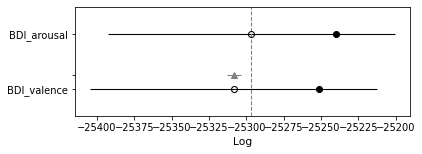

In [4]:
# Model comparison: use PSI-LOO

# Load each model
save_dir = '/home1/salman.qasim/Salman_Project/FR_Emotion/BayesModels'
BDI_arousal = az.from_netcdf(f'{save_dir}/recalled_BDI_arousal_allFRpts_model')
BDI_valence = az.from_netcdf(f'{save_dir}/recalled_BDI_valence_squared_allFRpts_model')

models = {"BDI_arousal": BDI_arousal, 
          "BDI_valence": BDI_valence}

df_compare = az.compare(models, ic='loo')
plot_df = df_compare.reset_index().rename(columns={'index':'model'})[['model', 'loo']]

c_string = '|c'*plot_df.shape[1] + '|'
print(plot_df.to_latex(index=False, 
                                        column_format=c_string).replace("\\\n", "\\ \hline\n"))  
az.plot_compare(df_compare, insample_dev=True)
plt.savefig(f'{save_dir}/BDI_arousal_valence_comparison.pdf')